In [1]:
""" Young experiment simulation using fdtd
TM simulation of a plane wave source impinging on a dielectric
screen with two narrow slits
"""
import numpy as np
from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data

import matplotlib.patches as patches # Plot rectangles

import glob
from PIL import Image
import re
import os

In [2]:
# Physical parameters of the problem.
c = 3e8           # The speed of light in vacuum.
epsr = 1e4        # The relative dielectric permittivity of the screen.
sigma = 0.3       # The conductivity of the screen.
epsz = 8.854e-12  # Permittivity of free space in SI units.

In [3]:
# Geometrical parameters of the problem. 
# The extent of the domain. **You can alter these parameters.**
ie = 200 # vertical limit.
je = 200 # horizontal limit.

# The central points in either directions.
ic = ie // 2 - 1
jc = je // 2 - 1

# The location of the perfectly matching layer.
ia = 10           # starting vertical position after PML.
ib = ie - ia - 1  # ending horizontal position before PML.
ja = 10           # starting horizontal position after PML.
jb = je - ja - 1  # ending horizontal position before PML.

# Slit geometry. **You can alter these parameters.**
slit_width = 8 # width of each slit (vertical measure).
slit_sep = 20 # separation between both slits (vertical measure).
screen_width = 8 # width of the screen (horizontal measure).

In [4]:
# The field vectors.
ez = np.zeros((ie, je)) # electric field
dz = np.zeros((ie, je)) # electric displacement
hx = np.zeros((ie, je)) # magnetic field in x
hy = np.zeros((ie, je)) # magnetic field in y
iz = np.zeros((ie, je))
ihx = np.zeros((ie, je))
ihy = np.zeros((ie, je))

ez_inc = np.zeros(je) # incident electric field
hx_inc = np.zeros(je) # incident magnetic field in x

In [5]:
# Simulation parameters and data.
ddx = 0.01 # Cell size in m
dt = ddx / 2*c
gaz = np.ones((ie, je))
gbz = np.zeros((ie, je))

boundary_low = [0, 0]
boundary_high = [0, 0]

t0 = 10       # Time for which the source is generated. **You can alter this parameter.**
nsteps = 500  # Number of time steps. **You can alter this parameter.**

# Vectors used for PML.
gi2 = np.ones(ie)
gi3 = np.ones(ie)
fi1 = np.zeros(ie)
fi2 = np.ones(ie)
fi3 = np.ones(ie)

gj2 = np.ones(je)
gj3 = np.ones(je)
fj1 = np.zeros(je)
fj2 = np.ones(je)
fj3 = np.ones(je)

# Dictionary to keep track of desired points for plotting.
plotting_points = []
for num_steps in range(1,nsteps+1):
    plotting_points.append({'label': 'a', 'num_steps': num_steps, 'data_to_plot': None})

In [6]:
# Functions used in simulation.
def build_dielectric_profile():
  for j in range(ja, jb): # vertical range
      for i in range(ia, ib): # horizontal range
          if (
              ((i > 0 and i < ic - slit_width/2-slit_sep/2) or 
              (i > ic - slit_sep/2 + slit_width/2 and i < ic + slit_sep/2 - slit_width/2) or 
              (i > ic + slit_width/2+slit_sep/2 and i < ie)) 
              and (j > jc-screen_width/2 and j < jc+screen_width/2)
              ): # If position is inside the dielectric
                  
              gaz[i, j] = 1 / (epsr + (sigma * dt / epsz))
              gbz[i, j] = (sigma * dt / epsz)
            
def create_pml():
  npml = ia + 1 # number of points for the PML
  for n in range(npml):
      xnum = npml - n
      xd = npml
      xxn = xnum / xd
      xn = 0.33 * xxn ** 3
      
      gi2[n] = 1 / (1 + xn)
      gi2[ie - 1 - n] = 1 / (1 + xn)
      gi3[n] = (1 - xn) / (1 + xn)
      gi3[ie - 1 - n] = (1 - xn) / (1 + xn)
      
      gj2[n] = 1 / (1 + xn)
      gj2[je - 1 - n] = 1 / (1 + xn)
      gj3[n] = (1 - xn) / (1 + xn)
      gj3[je - 1 - n] = (1 - xn) / (1 + xn)
      
      xxn = (xnum - 0.5) / xd
      xn = 0.33 * xxn ** 3
      
      fi1[n] = xn
      fi1[ie - 2 - n] = xn
      fi2[n] = 1 / (1 + xn)
      fi2[ie - 2 - n] = 1 / (1 + xn)
      fi3[n] = (1 - xn) / (1 + xn)
      fi3[ie - 2 - n] = (1 - xn) / (1 + xn)
      
      fj1[n] = xn
      fj1[je - 2 - n] = xn
      fj2[n] = 1 / (1 + xn)
      fj2[je - 2 - n] = 1 / (1 + xn)
      fj3[n] = (1 - xn) / (1 + xn)
      fj3[je - 2 - n] = (1 - xn) / (1 + xn)

def compute_fields(time_step): 
  # Print progress.
  if time_step%10 == 0: 
      print("\r",100*time_step/nsteps,'%', end="") 
  
  for j in range(1, je):
      ez_inc[j] = ez_inc[j] + 0.5 * (hx_inc[j - 1] - hx_inc[j])
              
  # Absorbing Boundary Conditions
  ez_inc[0] = boundary_low.pop(0)
  boundary_low.append(ez_inc[1])  
  ez_inc[je - 1] = boundary_high.pop(0)
  boundary_high.append(ez_inc[je - 2])
    
  for j in range(1, je):
      for i in range(1, ie):
          dz[i, j] = gi3[i] * gj3[j] * dz[i, j] + \
                      gi2[i] * gj2[j] * 0.5 * \
                      (hy[i, j] - hy[i - 1, j] -
                      hx[i, j] + hx[i, j - 1])

  # Source of electromagnetic waves.
  ez_inc[1] = (np.sin(2*np.pi*time_step/(2*t0)))**2
  
  for i in range(ia, ib + 1):
      dz[i, ja] = dz[i, ja] + 0.5 * hx_inc[ja - 1]
      dz[i, jb] = dz[i, jb] - 0.5 * hx_inc[jb]
      
  for j in range(0, je):
      for i in range(0, ie):
          ez[i, j] = gaz[i, j] * (dz[i, j] - iz[i, j])
          iz[i, j] = iz[i, j] + gbz[i, j] * ez[i, j]
                  
  for j in range(0, je - 1):
      hx_inc[j] = hx_inc[j] + 0.5 * (ez_inc[j] - ez_inc[j + 1])
      
  for j in range(0, je - 1):
      for i in range(0, ie - 1):
          curl_e = ez[i, j] - ez[i, j + 1]
          ihx[i, j] = ihx[i, j] + curl_e
          hx[i, j] = fj3[j] * hx[i, j] + fj2[j] * \
                      (0.5 * curl_e + fi1[i] * ihx[i, j])
              
  for i in range(ia, ib + 1):
      hx[i, ja - 1] = hx[i, ja - 1] + 0.5 * ez_inc[ja]
      hx[i, jb] = hx[i, jb] - 0.5 * ez_inc[jb]
      
  for j in range(0, je):
      for i in range(0, ie - 1):
          curl_e = ez[i, j] - ez[i + 1, j]
          ihy[i, j] = ihy[i, j] + curl_e
          hy[i, j] = fi3[i] * hy[i, j] - fi2[i] * \
                      (0.5 * curl_e + fj1[j] * ihy[i, j])
  
  for j in range(ja, jb + 1):
      hy[ia - 1, j] = hy[ia - 1, j] - 0.5 * ez_inc[j]
      hy[ib, j] = hy[ib, j] + 0.5 * ez_inc[j]
      
  # Save data at certain points for later plotting
  for plotting_point in plotting_points:
      if time_step == plotting_point['num_steps']:
          plotting_point['data_to_plot'] = np.copy(ez)



In [7]:
# The main simulation.
build_dielectric_profile()
create_pml()

print('Starting FDTD...')
for time_step in range(1, nsteps + 1):
  compute_fields(time_step)

Starting FDTD...
 100.0 %

In [13]:
'''
This cell saves the images of the data collected
'''
# filepaths
if not os.path.exists('figs'):
    print('Folder "figs" already exists. Saving/replacing images inside it...')
    os.makedirs('figs')    
else:
    print('Creating folder "figs". Saving images inside it...')
    
pwd = os.getcwd()
os.chdir('figs')    
    
plt.rcParams['font.size'] = 12
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = 'dotted'

print('Starting to save images to make gif...')
for subplot_num, plotting_point in enumerate(plotting_points):
    if subplot_num%10 == 0:
        print("\r",100*subplot_num/nsteps,'%', end="")
        
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    # Plot the dielectric in white color
    rect1 = patches.Rectangle((jc-screen_width/2,0),screen_width,ic-slit_sep/2-slit_width/2,linewidth=1,edgecolor='#ffffff',facecolor='#ffffff')
    rect2 = patches.Rectangle((jc-screen_width/2,ic-slit_sep/2+slit_width/2),screen_width,slit_sep-slit_width,linewidth=1,edgecolor='#ffffff',facecolor='#ffffff')
    rect3 = patches.Rectangle((jc-screen_width/2,ic+slit_sep/2+slit_width/2),screen_width,ic-slit_sep/2-slit_width/2,linewidth=1,edgecolor='#ffffff',facecolor='#ffffff')
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)

    plt.imshow(plotting_point['data_to_plot'], interpolation='bilinear', cmap='gist_heat')
    plt.savefig('figs_%s.png'%str(subplot_num+1))
    plt.close()
    
os.chdir(pwd)

Creating folder "figs". Saving images inside it...
Starting to save images to make gif...
 98.0 %

In [15]:
'''
This cell makes a gif using the images obtained
First it transforms the images names to integers in order to sort them
'''
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    return l
    
fp_in = "figs_*.png"
fp_out = "YoungMovie.gif"

pwd = os.getcwd()
os.chdir('figs')    

img, *imgs = [Image.open(f) for f in sort_nicely(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=20, loop=0, optimize=True) # duration: time of each frame in miliseconds

os.chdir(pwd)

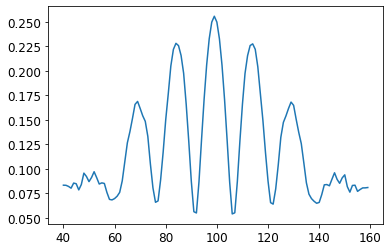

In [16]:
'''
This cell computes the averaged (total) electric field after the slits
'''

x = []
x1 = 40 # Starting vertical position
x2 = 160 # Final vertical position

# Construct array with x values, along vertical position from x1 to x2
for i in range(x1, x2):
    x.append(i)
    
# Here we compute an averaged field over two times t1 and t2
average = 0
t1 = nsteps - 100
t2 = nsteps - 1
y_measure = 150 # Horizontal position where the filed is to be measured

for i in range(t1, t2):
    average += abs(plotting_points[i]['data_to_plot'][x1:x2, y_measure])

# Plot the averaged field
ignore = plt.plot(x, average/(t2-t1))